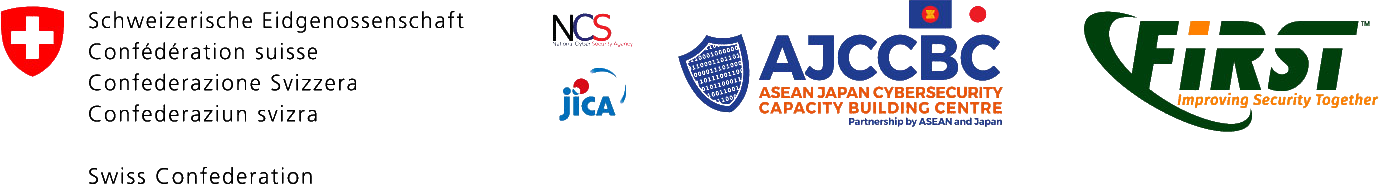  

<p></p>
<h1>Introduction to Jupyter</h1>

by Serge Droz and Eireann Leverett 

A lot of incident response work is about analyzing and enriching data. Some of this will be done on a daily basis, others is incident specific.

Jupyter notebooks are a powerful tool helping incident responders to to develop new analysis methods, investigate data and annotate the work. Jupyter notebooks can be shared, or even worked on collaboratively if run on a Jupyter Hub. 

This notebook gives an introduction to Jupyter as well as to some tools useful in incident response.
It assumes you do have a basic understanding of python. There are many [tutorials](https://wiki.python.org/moin/BeginnersGuidehttps://wiki.python.org/moin/BeginnersGuide) available online.

## Initialization 

Please run the cell below by **putting the mouse into the cell** and then **pressing *shift enter***. It will initialize things. If this runs in jupyterlite it may take a while.

In [ ]:
# Some intitialisation
# If we run in jupyterlit we need to install dnspython. Since jupyterlite does not support sockets the fuctionality will be reduced. 
try:
    import piplite
    await piplite.install('dnspython')
except:
    pass

<h2>Jupyter and JupyterLab</h2>

[Jupyter](https://jupyter.org/) developed out of the the IPython project. It allows people to interactively explore data and store the analysis in notebooks. Out of this came JupyterLab which can be called an IDE for Jupyter Notebooks. 

JupyterLab supports different languages. In this training we will focus on Python. 

<h3>JupyterLab</h3>

Familiarize yourself with the GUI. 

<b>Assignment</b>: Turn on line numbers

<h2>First steps</h2>

In this section we get familiar with Jupyter Notebooks. Each cell can either me *Markdown* (like this one), or *Code* (like the next one). We don't use the other states in this course. 

Markdown cells are used to document and can contain LaTeX formulas like

$R_{S} = \frac{2 M g }{c^2}$.

Code cells contain code. To execute a cell, enter it and press `Shift` + `Return`

Try this now:

In [ ]:
(1+1) * 12345

### Some Jupyter and Jupyterlab magic

There are a couple of nice features when working in a Jupyter environment. 

#### Old output

The output of the last cell executed is contained in the variable `_`. 
This is very useful if you forgot to somehow save the result of a long calculation. 

In [ ]:
_

Jupyter extends this to allow you to access to access the output of a *cell* X type `_X`

In [ ]:
_3

You can also get the content of the cell itself by executing `_iX`

In [ ]:
_i5

#### Magic commands

Jupyterlab, or rather the underlying defines a couple of [magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html) that allow you manipulate settings or execute commands outside Jupyter. 
These magic commands start with a `%` sign.

Here are a couple of file commands: `%pwd`, `%ls` or `%cd path`. Try them out below:

In [ ]:
%pwd

# A gentle intorduction into Data Analysis for incident response

Investigating an incident is quite often making sense of large amounts of data, in particular logs. Typically, after a breach happened incident responders will want to get a quick idea of what happened, and how the breach can be detected in the logs.

Afterwards, logs can be systematically searched for these signs, or other IOCs. Especially in large networks this can help to quickly get an overview and identify affected systems. 

The P in APT stands for persistence: It's thus often important to observe the situation for an extended period of time to ensure intruders have no longer any access to the networks. Monitoring for known artefacts in logs helps, but is tedious unless it's kind of automated. 

## Preparing data

Most data, and that is true for log data too, is typically not ready to be processed. It needs to cleaned and possibly enriched. Often logs are in a format that is not easily machine readable or suitable for the tools available. Thus data has to be cleaned.

### Case study: webserver logs

In the following we will analyze webserver logs. These particular logs come from a honey-pot 🍯, but the ideas apply to all kinds of logs. 

The log format, per the servers config is:

```
$remote_addr - $remote_user [$time_local] "$request" $status $body_bytes_sent "$http_referer" "$http_user_agent" "$http_x_forwarded_for" $server_port $host;
```


An example entry is:

```
8.26.182.72 - - [15/Jul/2022:04:44:54 +0200] "GET / HTTP/1.1" 200 3167 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWeb
Kit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36" "-" 443 212.237.24.77
```

**Assignment**: Write a regular expression that parses this line. 

In [ ]:
import re
line = '8.26.182.72 - - [15/Jul/2022:04:44:54 +0200] "GET / HTTP/1.1" 200 3167 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36" "-" 443 212.237.24.77'

parse_log_line = re.compile( r'Your regexp here' )

parse_log_line.findall( line )


Let us check if this works on different lines. The file `sample-log-01.txt` contains some logs. We'll read it and try to look at the result.

In [ ]:
def read_logs( filename ):
    """Read in a ngnix log and split it into fileds"""
    with open( filename ) as fp:
        for i, line in enumerate(fp.read().split("\n")):
            if not line:
                continue
            if  len ( parse_log_line.findall( line ) ): 
                print( "Line {:2d} ok".format(i))
            else:
                print( "Line {:2d} error".format(i))
                
read_logs( 'data/sample-log-01.txt' )

Writing regular expressions is tricky, but it is often the only way to poroperly parse logs. One that seems to work is given below. But feel free to use your own. 

In [ ]:
parse_log_line = re.compile( r'([0-9a-f:\.]+) - ([^\s]+) \[([^\]]+)] "([^\"]*)" (\d+) (\d+) "([^\"]*)" "([^\"]*)" "([^\"]*)"\s*(\d*)\s*([^\s]*)$'  )

## Pandas and Dataframes

The naive way of processing data is to read it into an array of arrays and the get working on it. Many scripting languages, and in particular python is not very efficient with this when processing large amounts of data. This has several reasons:

 - Python is a scripting language, code is translated to byte code which then is executed. While quite efficient it is no where as fast as native C implementations.
 - In python arrays are lists of pointers to the entries, because you can add whatever you want. This introduces a lot of overhead.
 
 This is not a new issue. To address it [NumPy](https://numpy.org/) was introduce in 2005 and introduce C based arrays. Based on NumPy in 2009 [Pandas](https://pandas.pydata.org/) was created to generalize this to, what's called *data frames*.
 
In this training we will leverage the power of Pandas and give you an idea of what you can do. But it is not about Pandas, it's about using such tools in your incident response work. 

So let us first adapt the old `read_logs` function to actually read and store the logs. 

Note, that on line 12, we append \*tmp, as our regex returns 

`[(ip, ....)]`

In [ ]:
def read_logs( filename ):
    """Read in a ngnix log and split it into fileds.
       filname: the name of the logfile
       Returns: an list of lists containing the logs"""
    data = []
    with open( filename ) as fp:
        for i, line in enumerate(fp.read().split("\n")):
            if not line:
                continue
            tmp = parse_log_line.findall( line ) 
            if  len ( tmp ): 
                data.append( *tmp )
            else:
                print( "Error parsing line {:2d}".format(i))
    return data

data = read_logs( 'data/sample-log-01.txt' )
data

As you can see this is not very user friendly, let's create a pandas data frame out of this. By convention data frames are named df, but you can, of course, choose any name. 

In [ ]:
import pandas as pd

df = pd.DataFrame( read_logs( 'data/sample-log-01.txt' ) )
df

This already looks better. But we are missing column headers. But they are easily supplied. Pandas can ingest a variety of data formats, `json`, `csv`, etc. form which it infers the column names. Since log files don't have this info we provide it manually. To get the syntax you can type the function and then get it's description by pressing `Ctrl-Tab`. Try it:

In [ ]:
df = pd.DataFrame( read_logs( 'data/sample-log-01.txt' ) # Type Ctrl-Tab here )
                 )
df

Correct, it's the columns key word

In [ ]:
columns= [ "IP", 'User', 'Time', 'Request', 'Status', 'Body Bytes', 'Referer', 'User-Agent', 'Forwarded', 'Dest-Port', 'Host']

df = pd.DataFrame( read_logs( 'data/sample-log-01.txt' ), columns=columns)
df

This looks already much nicer, but we can do better. However all entries are strings. You can specify the data type directly on a per column basis when importing a csv, but not here. We have to apply this conversion later. This is done by operating on an entire columns. This is very efficient and is kind of the philosophy behind pandas. rather than iteration on individual cells you operate on rows or columns. Since Pandas is written in C this is a lot faster.

There are many ways of doing this. A fairly common one is using `apply` which takes a function as argument and applies it to each value in a column (or row). Technically this returns a `Series`, nut think of a new column or row. You can assign this result either to a new column or overwrite an existing one. Here we do the latter. 

We first convert `Status`, `Body Bytes` and `Dest-Port` to integers. We then convert the timestamp to a python `datetime` object, using the pandas built in function `pandas.to_datetime( )`. 

In [ ]:
df = pd.DataFrame( read_logs( 'data/sample-log-01.txt' ), columns=columns )
df['Status']     = df['Status'].apply( lambda x: int(x))
df['Body Bytes'] = df['Body Bytes'].apply( lambda x: int(x))
df['Dest-Port']  = df['Dest-Port'].apply( lambda x: int(x))
df['Time'] = pd.to_datetime( df['Time'], format="%d/%b/%Y:%H:%M:%S %z" , utc=True )
df['Time'] = df['Time'].apply( lambda x: x.tz_convert('UTC').tz_localize(None) ) # Convert to UTC
df

### A note on timestamps

Timestamps are crucial when analyzing logs files. One of the biggest sources of fatal mistakes are wrong time zones. It is best practice to store logs in UTC, or if this is not feasible store time zone information along. Timestamps without timezone information are useless. 

Here we convert all timestamps to UTC and then remove the timezone info in the note book. This will make working with date a lot easier, as there is no ambiguity. 

This is done with the rather clumsy expression 
```
lambda x: x.tz_convert('UTC').tz_localize(None) 
```

The important takeaways are:
 - **Ensure your timezone information is correct**
 - **Agree on a timezone to work in (we recommend UTC) and stick to it**

Let us merge all this into one function. Developing a notebook often follows this iterative approach. One starts with a simple task, i.e. reading the log file and splitting it up into components. Then adding some further sanitation. Depending on the situation this may be quite complex. 

At the end you group things together. How much should go into one function is a matter of taste, but typically thins that belong together logically can go into one function. Find your own style, and stick to it. 

In [ ]:
def read_logs( filename ):
    """Read in a ngnix log and split it into fileds.
       filname: the name of the logfile
       Returns: a data frame containing the log"""
    data = []
    with open( filename ) as fp:
        for i, line in enumerate(fp.read().split("\n")):
            if not line:
                continue
            tmp = parse_log_line.findall( line ) 
            if  len ( tmp ): 
                data.append( *tmp )
            else:
                print( "Error parsing line {:2d}".format(i))

    columns= [ "IP", 'User', 'Time', 'Request', 'Status', 'Body Bytes', 'Referer', 'User-Agent', 'Forwarded', 'Dest-Port', 'Host']


    df = pd.DataFrame( data, columns=columns )
    df['Status']     = df['Status'].apply( lambda x: int(x))
    df['Body Bytes'] = df['Body Bytes'].apply( lambda x: int(x))
    df['Dest-Port']  = df['Dest-Port'].apply( lambda x: int(x))
    df['Time'] = pd.to_datetime( df['Time'], format="%d/%b/%Y:%H:%M:%S %z" , utc=True )
    df['Time'] = df['Time'].apply( lambda x: x.tz_convert('UTC').tz_localize(None) ) # Convert to UTC
    return df

df = read_logs( 'data/sample-log-01.txt' )
df

So let's try this with a full server log. Do the above but with the file `webserver-log-01.txt`. 

Does your regex work?


In [ ]:
df = read_logs( 'data/webserver-log-01.txt' )
df

Obviously something went wrong. Any idea what? (Click the the ... below for an answer)

The problem seems to be that the column `Dest-Port` cannot be converted. The reason is, that this seems to have been added to the log file at some later point. This is quite typical: Data often is not consistent. 

Here the fix is simple. Replace the line
```
df['Dest-Port']  = df['Dest-Port'].apply( lambda x:  int(x)  )
```
by 
```
df['Dest-Port']  = df['Dest-Port'].apply( lambda x:  int(x) if x else -1  )
```
We will thet back to this topic again with more detail.

In [ ]:
def read_logs( filename ):
    """Read in a ngnix log and split it into fileds.
       filname: the name of the logfile
       Returns: a data frame containing the log"""
    data = []
    with open( filename ) as fp:
        for i, line in enumerate(fp.read().split("\n")):
            if not line:
                continue
            tmp = parse_log_line.findall( line ) 
            if  len ( tmp ): 
                data.append( *tmp )
            else:
                print( "Error parsing line {:2d}".format(i))

    columns= [ "IP", 'User', 'Time', 'Request', 'Status', 'Body Bytes', 'Referer', 'User-Agent', 'Forwarded', 'Dest-Port', 'Host']


    df = pd.DataFrame( data, columns=columns )
    df['Status']     = df['Status'].apply( lambda x: int(x))
    df['Body Bytes'] = df['Body Bytes'].apply( lambda x: int(x))
    df['Dest-Port']  = df['Dest-Port'].apply( lambda x:  int(x) if x else -1  )
    df['Time'] = pd.to_datetime( df['Time'], format="%d/%b/%Y:%H:%M:%S %z" , utc=True )
    df['Time'] = df['Time'].apply( lambda x: x.tz_convert('UTC').tz_localize(None) ) # Convert to UTC
    return df
df = read_logs( 'data/webserver-log-01.txt' )
df

## Investigating data

Let us investigate this data a bit. Looking at new logs it's not always clear what the interesting entries are. The only way to find out is playing with the data. 

A very valuable strategy is looking at the distribution of values. i.e. how many different values are there. Is it something very rare? Or are there more entries than you expect? Or is there something in the middle ground that might be interesting. 

To start with let's look at user-agents

### User-Agents - value_counts()

The dataframe method `value_counts()` counts returns a pandas Series (think of a labeled array) of the counts of values. 

In [ ]:
tmp = df['User-Agent'].value_counts()
tmp

As usual, Pandas shows the the first and last five entries. What do you see?

The first handful of entries are likely common user-agents. Let's look at the first 20 entries. We can do this by using the normal slicing notion:

In [ ]:
tmp[:20]

Most User-Agents are fairly long. So let's look at entries which are short:

In [ ]:
df[df['User-Agent'].str.len() < 40 ][['IP','User-Agent']]

This introduces some new concepts for dataframes:

 1. Selecting based on a condition. 
 2. Only displaying selected columns
 
 However let's see if we certain IPs do can be correlated to certain User-Agents.
 

In [ ]:
df[df['User-Agent'].str.len() < 50 ].groupby(['IP','User-Agent']).size().reset_index(name='Count').sort_values(by=['Count'],ascending=False)

This is done using `groupby()` which by itself returns a `pandas.core.groupby.generic.DataFrameGroupBy object`. This object can be processed further. The `reset_index()` then creates a dataframe again, which we sort. 

This gives us a list of IPs that can be further investigated. 

Let us now look at User-Agents containing unusual characters. 


In [ ]:
df[df['User-Agent'].str.contains('<') ]['User-Agent']

This clearly looks lie an attempted SQL injection

In [ ]:
df[df['User-Agent'].str.contains('(?:<|\$|>|\?|\|)') ]['User-Agent']

Note, that we now have supplied a regular expression `(?:<|\$|>|\?|\|)`. Any idea what we see?

We can no extract the IPs, as they are obviously malicious:

In [ ]:
df[df['User-Agent'].str.contains('(?:<|\$|>|\?|\|)') ]['IP'].unique()

### requests - finding substrings
Let us now look at the URLs or rather the requests. As before we first take a look at the data. 

In [ ]:
df['Request']

Just plain requests are probably not interesting, so let's exclude them. This is achieved by prepending a boolean expression by a `~`. 

In [ ]:
df[~df['Request'].str.contains('^GET / HTTP/')]['Request']

Obviously a lot of scanning is going on. Many of the requests are very obvious, others less so. But often you can find the specific vulnerability they are scanning for. For example the expression `^GET /s/..x/_/;/(?:META|WEB)-IN` tries to exploit a bug in Jira: https://github.com/ColdFusionX/CVE-2021-26086

Can you find the respectve entries?


In [ ]:
df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')][['IP','Request']]

In [ ]:
df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')]['IP'].value_counts()

The first IP resolves to `probe-nl001.rand0.leakix.org` which seems to be a security scanner (See [leakIX](https://leakix.net/). Looking at the User-Agent gives again more information. See [l9explor](https://github.com/LeakIX/l9explore). The other IPs are from cloud providers, and don't really give any further information. It's probably safe to assume they are malicious. 

In [ ]:
df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')][['IP','User-Agent']]

Let us now look at IPv4 addresses in requests. Typically these are some form of injections. You should be able to search these entries yourself. It turns out that the output is fairly wide, but pandas tends to truncate this, which is annoying if you just paid a lot of money for a super wide screen. It's easy to tell pandas to use the full width available. 

Can you guess what these requests are? 


In [ ]:
old_witdh = pd.options.d['display']['max_colwidth']
pd.options.d['display']['max_colwidth'] = 0
display(df[df['Request'].str.contains('\d+\.\d+\.\d+\.\d+')][['IP','Request']])
pd.options.d['display']['max_colwidth'] = old_witdh

You likely guessed it: These are Mirai infections. 

## Visualizing logs

So far we only looked 👀 at the data. This is great to get an idea of what there might be, but it's bad conveying the bigger picture. Jupyter is a great tool to visualize you data. Pandas itself has some visualization build in. For example let's look at the IPs trying to exploit the Jira bug above. 

### Simple overviews

In [ ]:
_ = df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')]['IP'].value_counts().plot(kind='pie')

Similarly on create bar plots. This is a quick method to get an idea. 

In [ ]:
_ = df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')]['IP'].value_counts().plot(kind='bar')

### Using matplotlib 

This gives a already a good idea, but the plot looks a bit meager. While Pandas allows some configuration, it's best to leverage the full power of the underlying matplotlib. It allows you to customize your plots a lot. To show plots inline we use the magic command `%matplotlib inline`.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  


colors = ["#ffd700","#ffb14e","#fa8775","#ea5f94","#cd34b5","#9d02d7","#0000ff"][::-1]
fig, ax = plt.subplots( figsize=(8,8) )
df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')]['IP'].value_counts().plot(kind='pie', ax=ax, fontsize=18, colors=colors)
ax.set_title('IPs exploiting CVE-2021-26086', fontsize=24)
_ = ax.set_ylabel("")
_ = ax.add_artist(plt.Circle( (0,0), 0.6, color='white'))


### Time series plots
We can also plot the the entries over time. 

In [ ]:
tmp = df[df['Request'].str.contains('^GET /s/..x/_/;/(?:META|WEB)-IN')]
fig, ax = plt.subplots(figsize=(15,3))
ax.scatter(tmp['Time'],tmp['IP'])
plt.xticks(rotation=70, ha='right',fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('IPs exploiting CVE-2021-26086', fontsize=18)
ax.grid()


While at it, let's do the same for the log4j entries

In [ ]:
tmp = df[df['User-Agent'].str.contains('\$') ]
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(tmp['Time'],tmp['IP'])
plt.xticks(rotation=70, ha='right',fontsize=12)
plt.yticks(fontsize=12)
ax.set_title('IPs exploiting log4j', fontsize=18)
ax.grid()


### Binning

Often there is too much data to plot each individual point, or we're simply not interested in such detailed info. 

This is where binning is useful. Let us see if there is a daily variation of the log entries.


In [ ]:
import datetime

t_end = df.iloc[-1]['Time'].replace(hour=23, minute=59, second=59, microsecond=999999) 
t_start = t_end-datetime.timedelta(days=21)

bins = [ t_end - datetime.timedelta(days=i) for i in range(3 * 7  ,-1,-1) ]
labels = [ (t_end - datetime.timedelta(days=i)).strftime("%d.%m.%Y")  for i in range(3 * 7 - 1,-1,-1) ]
x = pd.cut(df[df['Time']>=datetime.datetime(t_start.year,t_start.month,t_start.day)]['Time'], bins, labels=labels, right=False)
ax = x.value_counts(sort=False).plot(kind="bar",figsize = (12,6))
ax.set_title('Request per day', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
_ = ax.grid()

Let us walk through this code, as it introduces some new concepts.

Let's first look at the expression 

```
df.iloc[-1]['Time']
```

You may have noticed that each data frame has an index. iloc allows you to access rows by index. And it supports the usual python slicing., i.e. `df.iloc[10:15]` would return rows 10-14 (five ros, starting at 10).

The `-1` signifies the last row, so what we do here is get the time of the last entry, assuming that the log is sorted. If this assumption is not true we could use `max()`. But for large datasets this is slower. 

In [ ]:
df['Time'].max()

The `replace()` functions set this timestamp to the end of the day. 

In the next line we create the bins. We count down 21 days from the last day in the set. We stop at `-1` because for the binning to work we need the endpoints included, i.e. n bins require n+1 entries in this array. 

Next we create the labels. Notice, that there is one label less, corresponding to the number of bins. Next the actual binning happens using the pandas function `cut()`. 

We then do a `value_count()` on this, which we plot. Note that plot returns the "axes" of the plot, i.e. the object that matplotlib operates on. 

Don't worry if you don't get the intricate details of what is going on here, this seems quite confusing. Most of the time one just uses existing code and adjusts it to the current needs, at leas that's what the author does. 

This ends the first introduction you should now be able to do the basic analysis of a set of log files. In the next session we will look at enriching data.

# Assignments

Below are a few assignments you can try to solve. 

## DNS over http

The log file contains entries from people sensing DNS over http queries. Can you find them? How would you go about this? Please try.

In [ ]:
# Try here

One solution is to search for entries containing the substring "dns=".

In [ ]:
tmp=df[df['Request'].str.contains('dns=')]
tmp

### Advanced: Analyse the query

The part after `dns=` is the base64 encoded query. Try to extract the actual query. To decode base64 use the function `base64.b64decode()`. This will return a raw dns query. You can decode this by feeding it into

```
import dns.message
dns.message.from_wire( raw_data  )
```

Play around, this will likely take some iterations to finish.


In [ ]:
# Try here

What queries do you find? Is this working as expected? 

A working solution is below:

In [ ]:
import base64
import dns.message

def extract_dns( x ):
    b64query = re.findall( r'dns=(.+)\s+',x)[0]
    #print( b64query )
    for p in [ '', '=', '==']:
        try:
            query = base64.b64decode( b64query + p )
            return str( dns.message.from_wire( query  ) )
        except Exception as e:
            msg = e
    return "error: {} -> {}".format(b64query, msg)
#extract_dns( "GET /resolve?dns=q80BAAABAAAAAAAAA3d3dwdleGFtcGxlA2NvbQAAAQAB HTTP/1.1" )
x = tmp['Request'].apply( extract_dns  )
x.unique()

## Analyze scanners

Some scanners have a specific keyword in their User-Agent field which identifies them. A list is below. (Many are recognized by their DNS name, which we will look at in the next lesson.)

In [ ]:
ua_scanner_keywords = [ 'project_patchwatch', 'scaninfo@expanseinc.com', 'project-resonance.com' ,
                            'gdnplus.com', 'censys.io', 'netsystemsresearch.com', 'Nmap Scripting Engine'
                            'internet-measurement.com', 'tchelebi.io', 'paloaltonetworks.com', 'security.ipip.net' ] 


Find all scanners log entries and plot a time series.

In [ ]:
# Try here

A solution is below. 

In [ ]:
def is_scanner( x ):
    for kw in ua_scanner_keywords:
        if kw in x:
            return True
    return False
    
tmp = df[df['User-Agent'].apply( is_scanner )]
tmp

In [ ]:
fig, ax = plt.subplots(figsize=(15,25))
ax.scatter(list(tmp['Time']),list(tmp['IP']), s=3 )
#plt.xticks(rotation=70, ha='right',fontsize=12)
plt.yticks(fontsize=6)
ax.set_title('IPs scanning', fontsize=18)
ax.grid()

## Conclusion

This concludes the first lesson. You should now have a basic understanding of Jupyter and pandas. Both are very complex and powerful tools, so don't despair if you don't understand certain things. You need to practice this. 

You also should understand that investigating an incident is an iterative process. Typically you improve your notebook for every new analysis. It's recommended to start a new investigation in a new notebook, rspt. a copy of an existing, and not reuse the old one. That way you don't accidentally delete something that used to work and you have an archive of your previous incidents. 

And finally: Do add ample comments, you'll be grateful for them two month in the future. 

### Next steps

In the next lesson we will look at enriching data with external information.